<a href="https://colab.research.google.com/github/Arrheniuss/LSTM_time_series_prediction/blob/main/LSTM_air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Wczytanie zbioru danych i wstępna analiza



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime
import tensorflow as tf
from IPython.display import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import r2_score, mean_squared_error
from keras.callbacks import EarlyStopping

In [ ]:
# Załadowanie zbioru danych
df = pd.read_csv("PRSA_Data_Wanshouxigong_20130301-20170228.csv")

In [ ]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong
1,2,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong
2,3,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong
3,4,2013,3,1,3,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong
4,5,2013,3,1,4,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong


In [ ]:
df.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,34368.000000,34580.000000,34395.000000,34310.00000,33767.000000,33986.000000,35045.000000,35045.000000,35045.000000,35045.000000,35051.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,85.024136,112.223459,17.148603,55.52956,1370.395031,56.229904,13.784477,1011.511804,2.707442,0.064320,1.745314
std,10122.249256,1.177213,3.448752,8.800218,6.922285,85.975981,97.593210,23.940834,35.80805,1223.139114,57.082710,11.385156,10.570928,13.704139,0.796981,1.206355
min,1.000000,2013.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.285600,2.00000,100.000000,0.214200,-16.800000,985.100000,-35.300000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,23.000000,39.000000,3.000000,28.00000,600.000000,8.000000,3.400000,1002.800000,-8.500000,0.000000,0.900000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,60.000000,91.000000,8.000000,49.00000,1000.000000,42.000000,14.800000,1011.000000,3.300000,0.000000,1.400000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,116.000000,154.000000,21.000000,77.00000,1700.000000,82.000000,23.500000,1020.000000,15.200000,0.000000,2.300000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,999.000000,961.000000,411.000000,251.00000,9800.000000,358.000000,40.600000,1042.000000,28.500000,46.400000,13.200000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34368 non-null  float64
 6   PM10     34580 non-null  float64
 7   SO2      34395 non-null  float64
 8   NO2      34310 non-null  float64
 9   CO       33767 non-null  float64
 10  O3       33986 non-null  float64
 11  TEMP     35045 non-null  float64
 12  PRES     35045 non-null  float64
 13  DEWP     35045 non-null  float64
 14  RAIN     35045 non-null  float64
 15  wd       34985 non-null  object 
 16  WSPM     35051 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [ ]:
print(df.columns)

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')


# 2. Przekształcenie i uzupełnienie pustych wartości

In [ ]:
# Przekształcenie kolumny 'year', 'month', 'day', 'hour' w jedną kolumne 'Date'
df['Date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors = 'coerce')

# Ustawienie kolumny 'Date' jako indeks
df.set_index('Date', inplace=True)

# Usuniecie oryginalnych kolumn plus kolumny station poniewaz nic nie wnosi do analizy
df.drop(['year', 'month', 'day', 'hour','No','station'], axis=1, inplace=True)

df.head()


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
Date,,,,,,,,,,,,
2013-03-01 00:00:00,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0
2013-03-01 01:00:00,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4
2013-03-01 02:00:00,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7
2013-03-01 03:00:00,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6
2013-03-01 04:00:00,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5


In [ ]:
df.describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,34368.000000,34580.000000,34395.000000,34310.00000,33767.000000,33986.000000,35045.000000,35045.000000,35045.000000,35045.000000,35051.000000
mean,85.024136,112.223459,17.148603,55.52956,1370.395031,56.229904,13.784477,1011.511804,2.707442,0.064320,1.745314
std,85.975981,97.593210,23.940834,35.80805,1223.139114,57.082710,11.385156,10.570928,13.704139,0.796981,1.206355
min,3.000000,2.000000,0.285600,2.00000,100.000000,0.214200,-16.800000,985.100000,-35.300000,0.000000,0.000000
25%,23.000000,39.000000,3.000000,28.00000,600.000000,8.000000,3.400000,1002.800000,-8.500000,0.000000,0.900000
50%,60.000000,91.000000,8.000000,49.00000,1000.000000,42.000000,14.800000,1011.000000,3.300000,0.000000,1.400000
75%,116.000000,154.000000,21.000000,77.00000,1700.000000,82.000000,23.500000,1020.000000,15.200000,0.000000,2.300000
max,999.000000,961.000000,411.000000,251.00000,9800.000000,358.000000,40.600000,1042.000000,28.500000,46.400000,13.200000


In [ ]:
# Sprawdzenie wartosci NaN w DataFrame
print(df.isnull().sum())

PM2.5     696
PM10      484
SO2       669
NO2       754
CO       1297
O3       1078
TEMP       19
PRES       19
DEWP       19
RAIN       19
wd         79
WSPM       13
dtype: int64


In [ ]:
# Usuniecie wartosci zerowych dla kolumny PM2.5 poniewaz to zmienna celu
df = df.dropna(subset=['PM2.5'])

In [ ]:
# Sprawdzenie wartosic po usunieciu Nan dla kolumny PM2.5
print(df.isnull().sum())

PM2.5      0
PM10      17
SO2      242
NO2      331
CO       872
O3       686
TEMP      19
PRES      19
DEWP      19
RAIN      19
wd        78
WSPM      13
dtype: int64


In [ ]:
# Uzupenienie pustych danych metodą interpolacji
df = df.interpolate(method='time')

<ipython-input-12-15a3e4d6a2ed>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time')


# 3. Eksploracyjna analiza danych

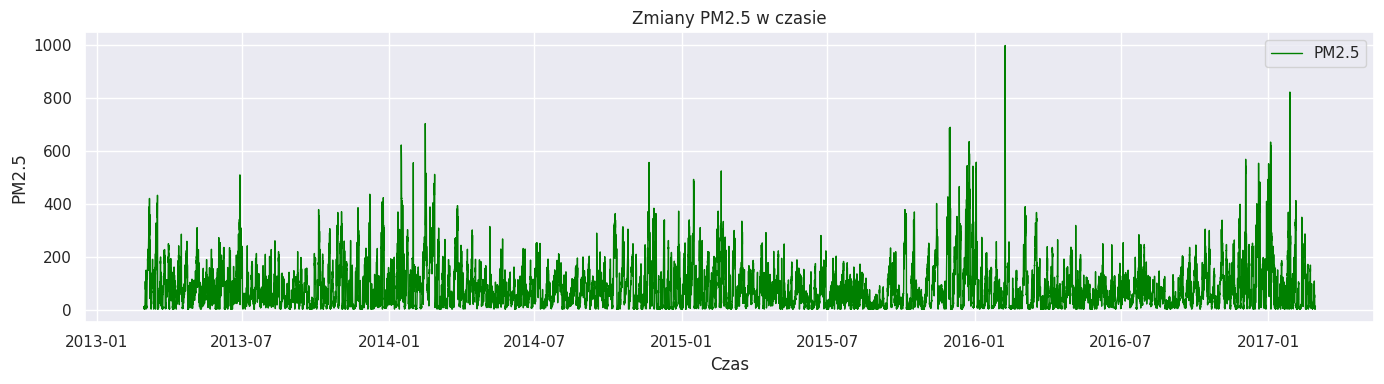

In [ ]:
# Wykres PM2.5 w czasie
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['PM2.5'], label='PM2.5', color='green', linewidth=1)
plt.title('Zmiany PM2.5 w czasie')
plt.xlabel('Czas')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

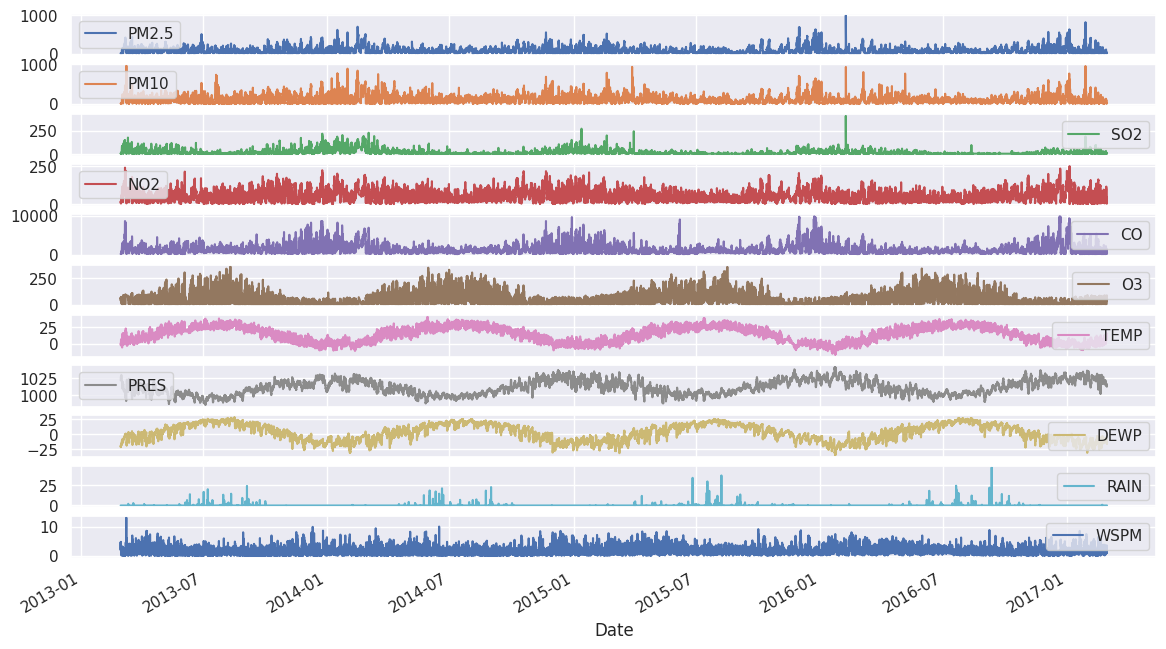

In [ ]:
ax1 = df.plot(figsize=(14, 8), subplots=True)

Wykresy z wartosciamy odstajacymi


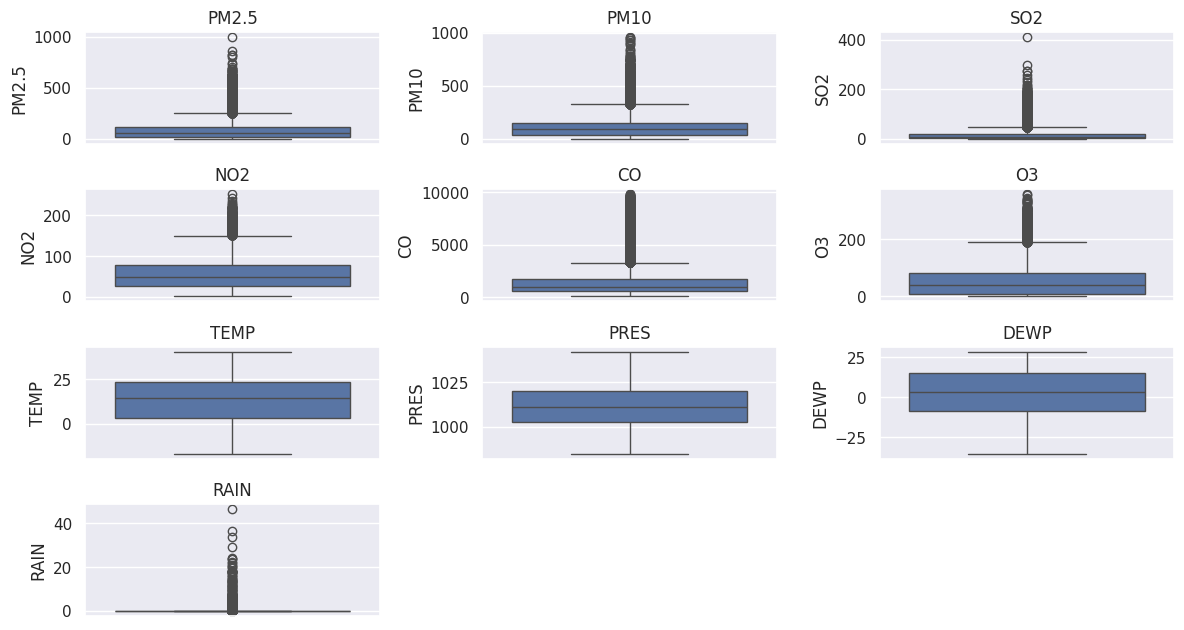

In [ ]:
print('Wykresy z wartosciamy odstajacymi')
columns = ['PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN']
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

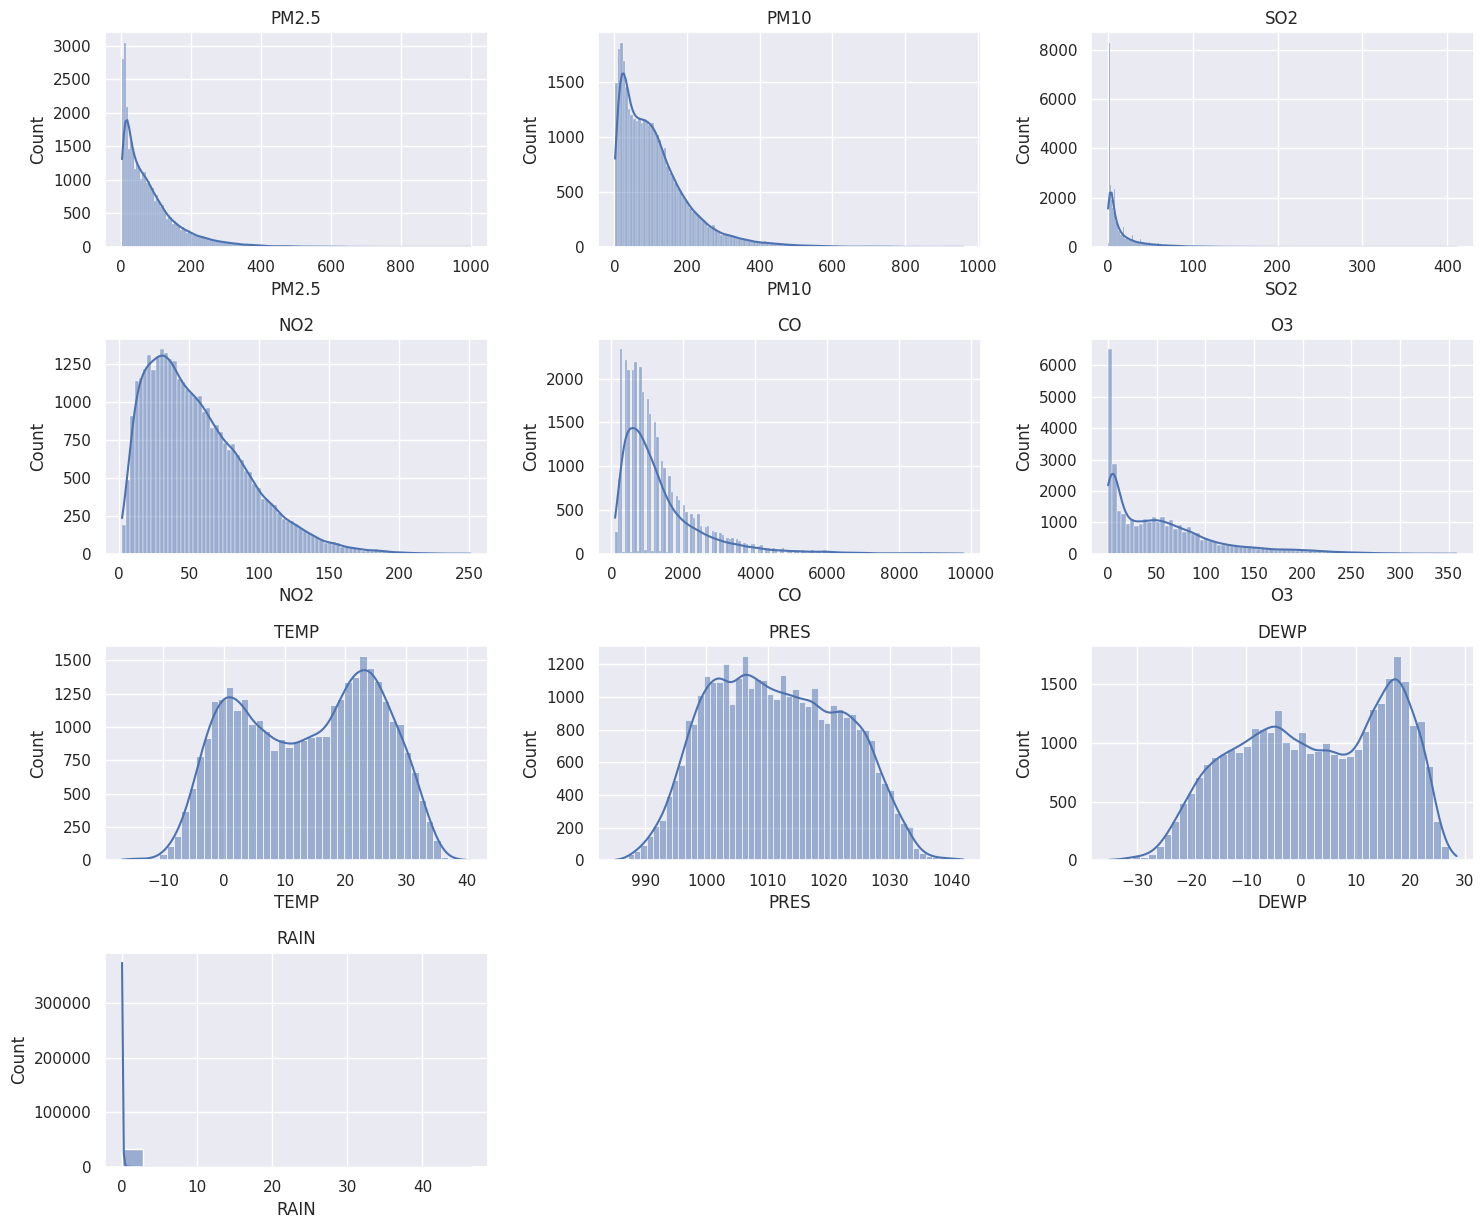

In [ ]:
# Rozkład zmiennych
plt.figure(figsize=(15, 15))
for i, column in enumerate(columns):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df[column], kde=True)  # Wykres histogramu z krzywą gęstości
    plt.title(column)

plt.tight_layout()
plt.show()

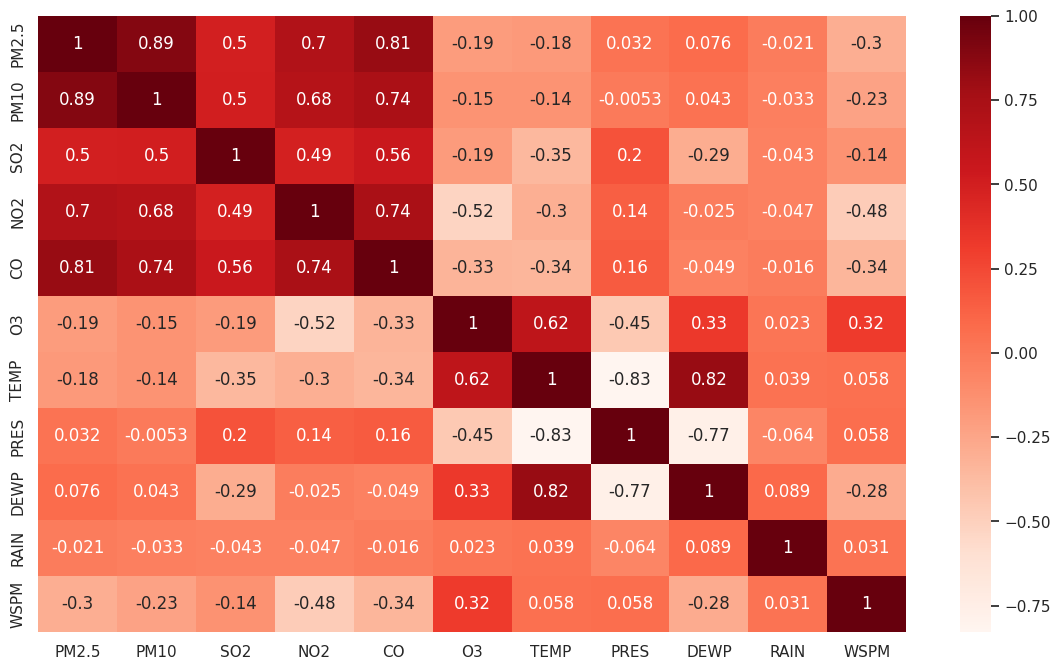

In [ ]:
# Macierz korelacji
corr_matrix = df.drop(['wd'], axis=1).corr()
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Reds')
plt.show()

# 4. Standaryzacja zmiennych, podział na zbiór testowy i treningowy

In [ ]:
# Podział danych na X i y
y = df['PM2.5']  # Zmienna celu
X = df.drop('PM2.5', axis=1)  # Zbiór wejściowy

# Skalowanie kolumn numerycznych
numeric_features = X.columns.difference(['wd'])
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_features])

# Kodowanie kolumny 'wd' za pomocą OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' usuwa nadmiarową kolumnę
X_categorical_encoded = encoder.fit_transform(X[['wd']])

# Usuniecie pierwotnej postaci
X = X.drop('wd', axis=1)

# Połączenie danych numerycznych i zakodowanych kategorycznych
X_scaled = np.hstack((X_numeric_scaled, X_categorical_encoded))

# Standaryzacja zmiennej celu y
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
print(X_numeric_scaled.shape)  # Powinno być (n_samples, n_numeric_features)
print(X_categorical_encoded.shape)  # Powinno być (n_samples, n_categorical_features)
print(X_scaled.shape)  # Powinno być (n_samples, n_numeric_features + n_categorical_features)
print(y_scaled.shape)  # Powinno być (n_samples,)

(34368, 10)
(34368, 16)
(34368, 26)
(34368, 1)


In [ ]:
# Obliczenie rozmiaru zbioru treningowego
train_size = int(0.9 * len(X_scaled))

# Podział danych
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [ ]:
# Utworzenie generatora
# Parametry generatora
sequence_length = 24  # 24 godziny
batch_size = 64       # Rozmiar paczki danych

# Generatory
train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=batch_size)

# Weryfikacja
X_sample, y_sample = train_generator_1[0]
print("Kształt paczki X:", X_sample.shape)  # (batch_size, sequence_length, n_features)
print("Kształt paczki y:", y_sample.shape)  # (batch_size,)

Kształt paczki X: (256, 24, 26)
Kształt paczki y: (256, 1)


# 5. Budowa modelu i trening

In [ ]:
# Kształt danych wejściowych
input_shape = (24, X_train.shape[1])  # 24 godziny, liczba cech wejściowych

# Budowa modelu
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh', return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                       │ (None, 24, 128)             │          79,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 24, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ (None, 24, 32)              │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 24, 1)               │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,817 (776.63 KB)

 Trainable params: 198,817 (776.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Kompilacja modelu
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
# Trening modelu
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=200,
    batch_size=256,
    callbacks = [es],
    verbose=1
)

Epoch 1/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - loss: 0.5586 - mse: 0.5586 - val_loss: 0.6332 - val_mse: 0.6332
Epoch 2/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.3170 - mse: 0.3170 - val_loss: 0.5597 - val_mse: 0.5597
Epoch 3/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2862 - mse: 0.2862 - val_loss: 0.2857 - val_mse: 0.2857
Epoch 4/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.2000 - mse: 0.2000 - val_loss: 0.3041 - val_mse: 0.3041
Epoch 5/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1727 - mse: 0.1727 - val_loss: 0.2382 - val_mse: 0.2382
Epoch 6/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1377 - mse: 0.1377 - val_loss: 0.3488 - val_mse: 0.3488
Epoch 7/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1957 - mse: 0.1957 - val_loss: 0.2599 - val_mse: 0.2599
Epoch 8/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1506 - mse: 0.1506 - val_loss: 0.2108 - val_mse: 0.2108
Epoch 9/200
483/483 ━━━━━━━━━━━━━━━━━━━

# 6. Ocena jakości treningu i wizualizacja rezultatów

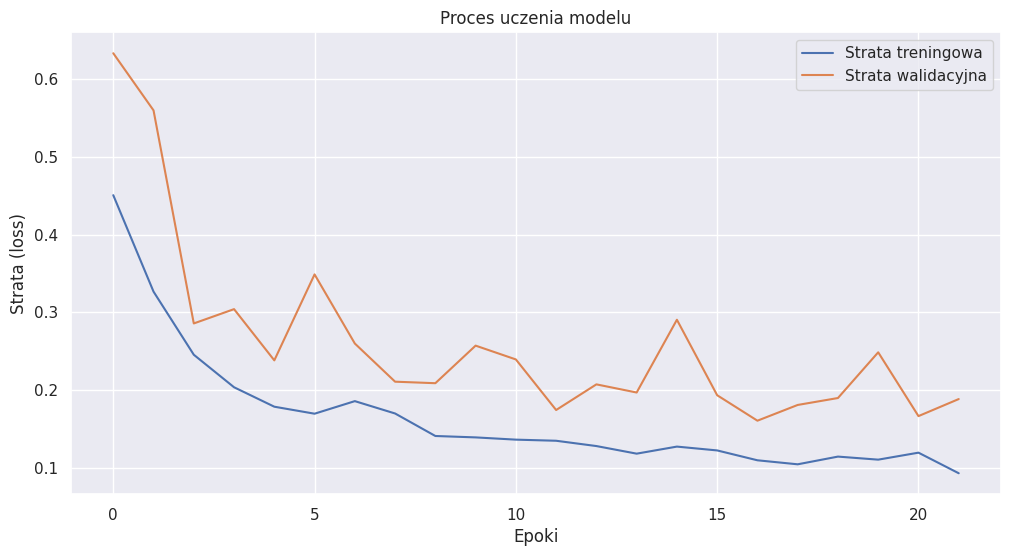

In [ ]:
# Wykres funkcji straty
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Proces uczenia modelu')
plt.xlabel('Epoki')
plt.ylabel('Strata (loss)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prognoza dla danych treningowych
y_train_pred_scaled = model.predict(train_generator)
y_train_pred_last = y_train_pred_scaled[:, -1, :]  # Pobranie ostatniej prognozy z każdej sekwencji
y_train_pred = y_scaler.inverse_transform(y_train_pred_last)

# Rzeczywiste wartości
y_train_original = y_scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_adjusted = y_train_original[sequence_length:]  # Dopasowanie długości

# Prognoza dla danych testowych
y_test_pred_scaled = model.predict(test_generator)
y_test_pred_last = y_test_pred_scaled[:, -1, :]  # Pobranie ostatniej prognozy
y_test_pred = y_scaler.inverse_transform(y_test_pred_last)

# Rzeczywiste wartości testowe
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_adjusted = y_test_original[sequence_length:]  # Dopasowanie długości

# Obliczanie metryk dla zbioru treningowego
mse_train = mean_squared_error(y_train_adjusted, y_train_pred)
r2_train = r2_score(y_train_adjusted, y_train_pred)

# Obliczanie metryk dla zbioru testowego
mse_test = mean_squared_error(y_test_adjusted, y_test_pred)
r2_test = r2_score(y_test_adjusted, y_test_pred)

# Wyświetlenie wyników
print("=== Metryki dla danych treningowych ===")
print(f"MSE (train) = {mse_train:.3f}")
print(f"R2 (train)  = {r2_train:.3f}")

print("\n=== Metryki dla danych testowych ===")
print(f"MSE (test) = {mse_test:.3f}")
print(f"R2 (test)  = {r2_test:.3f}")

483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
=== Metryki dla danych treningowych ===
MSE (train) = 635.521
R2 (train)  = 0.903

=== Metryki dla danych testowych ===
MSE (test) = 1234.298
R2 (test)  = 0.912


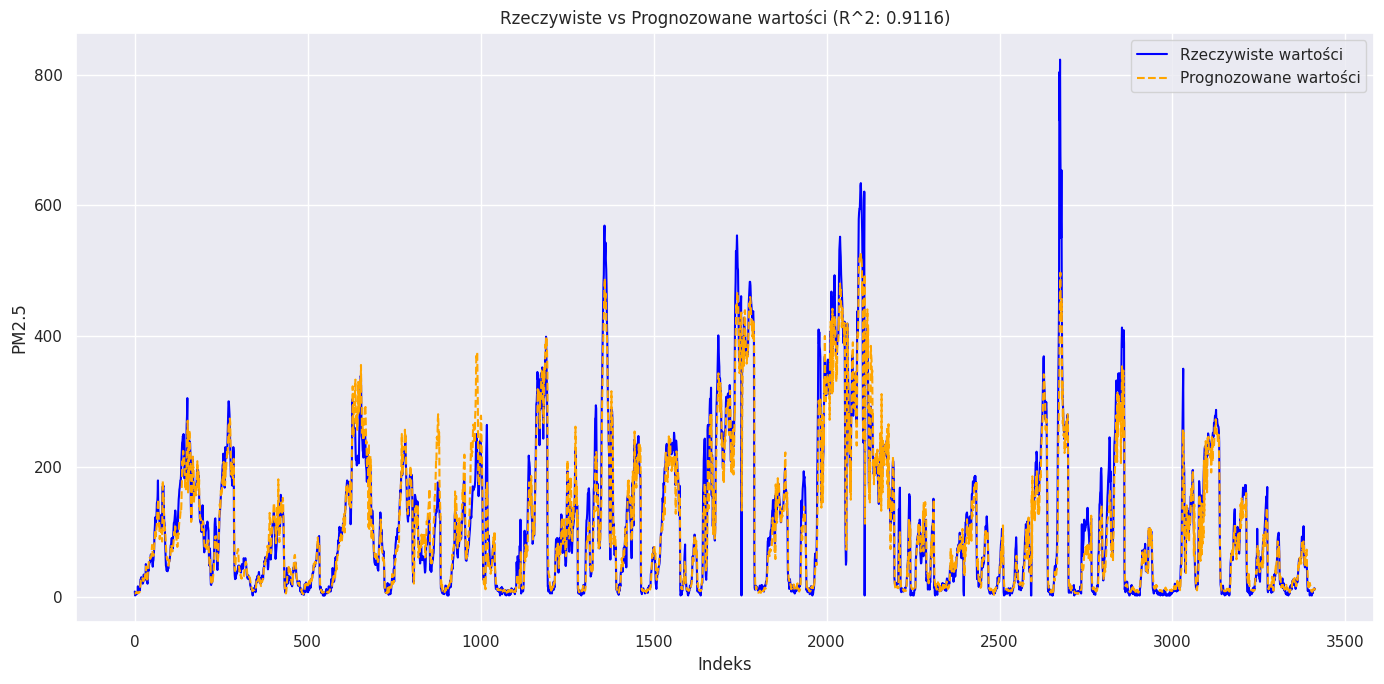

In [ ]:
# Wykres rzeczywiste vs prognozowane
plt.figure(figsize=(14, 7))
plt.plot(y_test_adjusted, label='Rzeczywiste wartości', color='blue')
plt.plot(y_test_pred, label='Prognozowane wartości', color='orange', linestyle='--')
plt.title(f'Rzeczywiste vs Prognozowane wartości (R^2: {r2_test:.4f})')
plt.xlabel('Indeks')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Wnioski



1. **Przebieg realizacji projektu**
*   Wstępna analiza danych:

  *   Identyfikacja zmiennych numerycznych i wartości odstających
  *   Wypełnienie brakujących danych za pomocą interpolacji

*   Podział na dane treningowe i testowe:

  *   Użycie sekwencyjnego podziału w celu zachowania chronologii danych czasowych
  *   Standaryzacja zmiennch wejściowych oraz zmiennej docelowej

*   Budowa modelu:

  *   Pierwszy model wykorzystywał podstawowe warstwy LSTM bez dropoutu
  *   Eksperymenty z różnymi wartościami batch_size
  *   Zastosowanie Bidirectional LSTM


*   Optymalizacja:

  *   Ulepszenie architektury modelu oraz optymalizacja hiperparametrów
  *   Dodanie Bidirectional LSTM i Dropout

2. **Wnioski**


*   Metryki jakosci:
  *   MSE (train): 635.521
  *   MSE (test): 1234.298
  *   R^2 (train): 0.903
  *   R^2 (test): 0.912

*   Wynik R^2 na poziomie 0.91 wskazuje, że model bardzo dobrze dopasowuje się do danych testowych. Mimo stosunkowo wysokiego MSE, model skutecznie wyjaśnia zmienność PM2.5


*   Początkowe wyniki modelu były znacznie gorsze, zanim zastosowano Bidirectional LSTM, jak widać dwukierunkowe sieci mogą znacząco poprawić wyniki w przypadku przewidywań szeregów czasowych, gdy zależności mogą być widoczne zarówno w przeszłości jak i przyszłości

*   Wartości odstające mogły wpłynąć na wysoki MSE. Być może dodatkowe filtrowanie lub inne podejście do przetwarzania wartości odstających poprawiłoby wyniki.


*   Zastosowanie warstw Dropout zapobiegło przetrenowaniu modelu i pozwoliło osiągnąć dobre wyniki na danych testowych.

3. **Podsumowanie ogólne**
*   Projekt wykazał, że odpowiedni dobór atchitektury modelu, długość sekwencji oraz optymalizacja hiperparametrów są kluczowe w osiągnięciu wysokich wyników w przypadku problemów przewidywań szeregów czasowych. Osiągnięte wyniki wskazują na potencjał modelu w zastosowaniach praktycznych, jednak jest możliwe dalsze zwiększenie dokładności poprzez eliminację wartości odstających oraz możliwe zastosowanie mechanizmów uwagi.






















